In [1]:
import LOM

## Steps:
Generate three types of process through kernels:
- Gaussian -1
- Increasing/Decreasing linear trend
- Gaussian -2
- Generate latent process and a random phi add noise
- Label processes as coming from increasing trend-G1 as 1’s and decreasing trend-G1/G2 as 0’s
- Increasing N, check classification accuracy 
- Increasing  n, check classification accuracy
- Compare with Logistic regression and LDA: Stretch goal


In [48]:
## Linear increasing kernel
import GPy
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
kenrel = GPy.kern.Linear(1,variances=0.001) * GPy.kern.Brownian(1,variance=3) + GPy.kern.Matern52(1,variance=2,lengthscale=3) 
print kenrel
N = 100
S =50
P = 2
C = 4
N = 100
s2 = 1
x = np.linspace(0,N-1,N)


  sum.                   |  value  |  constraints  |  priors
  mul.linear.variances   |  0.001  |      +ve      |        
  mul.Brownian.variance  |    3.0  |      +ve      |        
  Mat52.variance         |    2.0  |      +ve      |        
  Mat52.lengthscale      |    3.0  |      +ve      |        


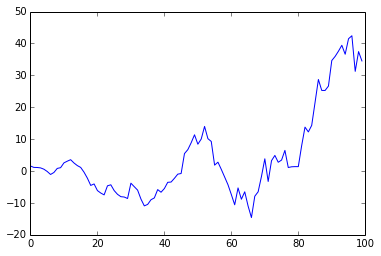

In [49]:
#Get trends
u = np.random.multivariate_normal(mean=np.zeros(N).flatten(),cov=kenrel.K(x.reshape(N,1)))
plt.plot(u)


In [42]:
increasingTrend = u
#decreasingTrend = u

In [25]:
## Two gaussian Processes:
gaussianKernel = GPy.kern.ExpQuad(1,lengthscale=2)
g1 = np.random.multivariate_normal(mean=np.zeros(N).flatten(),cov=gaussianKernel.K(x.reshape(N,1)))
g2 = np.random.multivariate_normal(mean=np.zeros(N).flatten(),cov=gaussianKernel.K(x.reshape(N,1)))

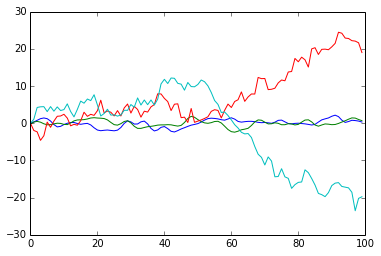

In [26]:
plt.plot(g1)
plt.plot(g2)
plt.plot(increasingTrend)
plt.plot(decreasingTrend)

Now we know our latent processes: g1,g2,increasingTrend,decreasingTrend
We sample phi and then combine these to generate data such that:
    - with probability 0.5:
        get g1 and increasing trend set Label to 1
     - With probability 0.5:
         get g1 or g2 with equal probability combine with decreasing trend and set label to -1
        

Phi
[[-1.14541802 -0.46561359]
 [ 0.27837266  1.68768097]
 [-0.15334267  0.0723105 ]
 [-0.32953363 -0.93886535]]


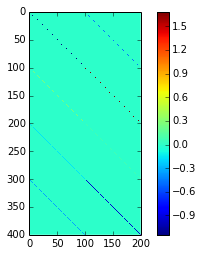

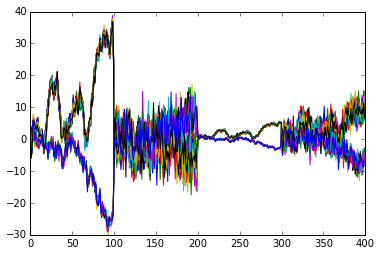

In [53]:
phi = np.random.normal(loc=0,scale=1,size=(C,P))
phiBar = np.matrix(np.kron(phi,np.eye(N)))
print "Phi\n",phi
plt.imshow(phiBar,interpolation='none')
plt.colorbar()
plt.show()
def guessLabel(l,mu=0):
    if l < mu:
        return -1
    else:
        return 1

B = np.ones(S)
W = np.random.rand(P*N)
uBar = np.matrix(np.ones((S,N*P)))
l = np.zeros(S)
L = np.zeros(S)
for s in range(S):
    if np.random.rand() < 0.3:
        L[s] = 1
        us = np.hstack([increasingTrend,g1+2*np.random.normal(0,1,increasingTrend.shape[0])])
    else:
        L[s] = -1
        if np.random.rand() < 0.5:
            us = np.hstack([decreasingTrend,g1+2*np.random.normal(0,1,increasingTrend.shape[0])])
        else:
            us = np.hstack([decreasingTrend,g2+2*np.random.normal(0,1,increasingTrend.shape[0])])
    uBar[s,:] = us
    l[s] = np.dot(uBar[s,:] ,W) + B[s]
    #L[s] = guessLabel(l[s])
YBar = uBar * phiBar.T + np.random.normal(0,s2)
i=plt.plot(YBar.T)

In [54]:
from sklearn.cross_validation import train_test_split
Y_train, Y_test, L_train, L_test = train_test_split(YBar, L, test_size=0.4, random_state=0)

(array([ 15.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   5.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

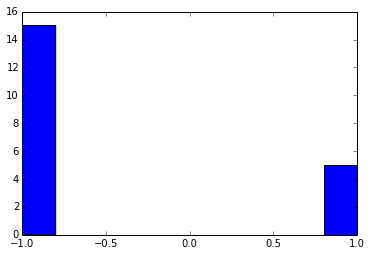

In [61]:
plt.hist(L_test)

### training

Concatenated Latent Gaussian Processes:
(300, 240) (240, 240) 0 15 30 45 60 75 90 105 120 135


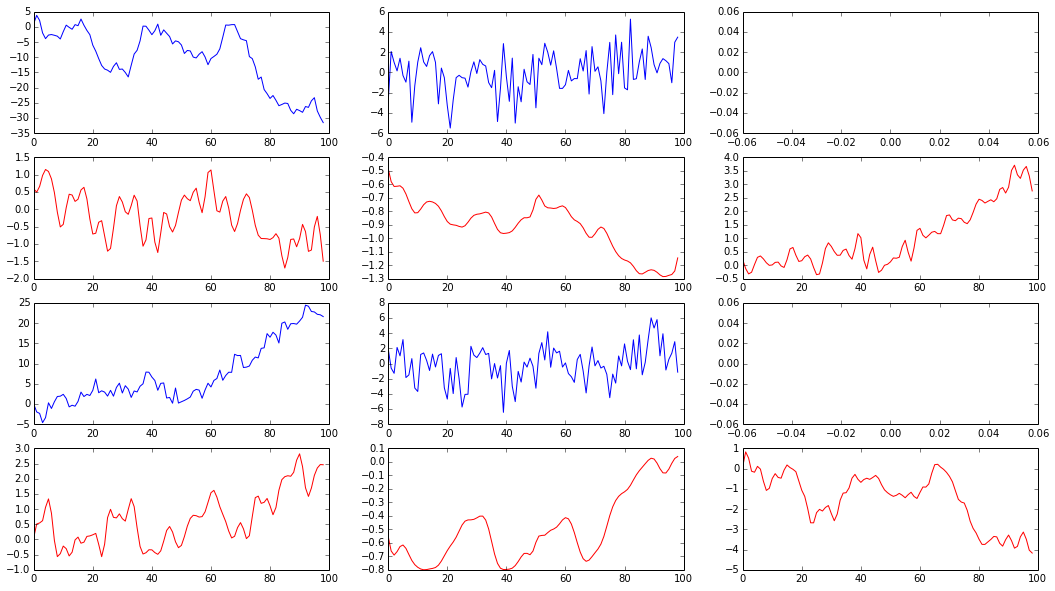

In [57]:
myModel = LOM.LOM(Y=Y_train,L=L_train,N=N,C=C,S=L_train.shape[0])
myModel.fit(n=int(N*0.8),iters=150,P=3)
plt.show()
fig,axes = plt.subplots(nrows=2*2,ncols=myModel.P,figsize=(18,10))
for s in range(2):
    for p in range(myModel.P):
        if p <= uBar.shape[1]/N:
            axes[2*s+0,p].plot(uBar[s,p*N:p*N+N-1].T)
        else:
            axes[2*s+0,p].plot(np.ones(N).T)
        axes[2*s+1,p].plot(myModel.uExpBar[s,p*N:p*N+N-1].T,c='r')

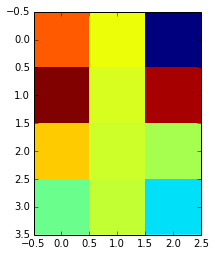

In [63]:
plt.imshow(myModel.phiHatExp,interpolation='None')

## Prediction

In [58]:
results,Expresults, _ = myModel.predict(Y_test)

In [59]:
results

array([-1.,  1., -1., -1., -1., -1.,  1., -1., -1.,  1., -1., -1., -1.,
        1., -1., -1., -1., -1., -1.,  1.])

In [60]:
L_test

array([-1.,  1., -1., -1., -1., -1.,  1., -1., -1.,  1., -1., -1., -1.,
        1., -1., -1., -1., -1., -1.,  1.])

In [64]:
acc = L ==LHat
acc.mean()

NameError: name 'LHat' is not defined